In [ ]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms.v2 as T
import torchvision.transforms.v2.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.training import *

In [ ]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

set_seed(42)

In [ ]:
xl,yl = 'image', 'label'
bs = 512
dsd = load_dataset("imagenet-1k")

In [ ]:
ds, val = dsd['train'], dsd['validation']

In [ ]:
class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds,self.tfmx,self.tfmy = ds,tfmx,tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        item = self.ds[i]
        return self.tfmx(item),self.tfmy(item)

In [ ]:
def transforms(images, tfmx = fc.noop, tfmy = fc.noop):
    images[xl] = [tfmx(img) for img in images[xl]]
    images[yl] = [tfmy(img) for img in images[yl]]
    return images

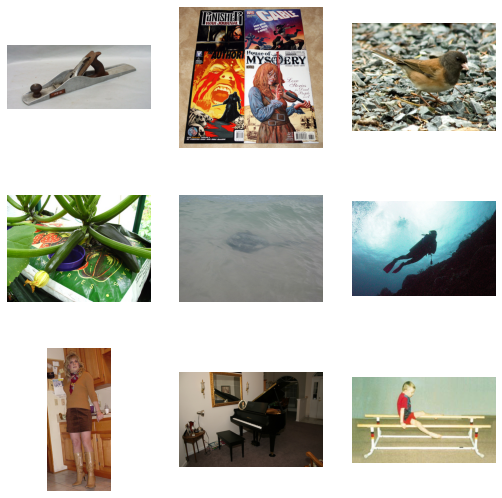

In [ ]:
show_images(ds[0:9][xl])

In [ ]:
tfmx = T.Compose([ T.CenterCrop((256,256)), T.ToImage(), T.ToDtype(torch.float32, scale=True), lambda x: x.expand(3,-1,-1)*2-1, T.Pad((2,2,2,2))])

In [ ]:
tfm_ds = ds.with_transform(partial(transforms,tfmx=tfmx))
tfm_val = val.with_transform(partial(transforms,tfmx=tfmx))

In [ ]:
tfm_ds[0]

{'image': tensor([[[0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000],
          [0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000],
          [0.00000, 0.00000, 0.27843,  ..., 0.49804, 0.00000, 0.00000],
          ...,
          [0.00000, 0.00000, 0.44314,  ..., 0.53726, 0.00000, 0.00000],
          [0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000],
          [0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000]],
 
         [[0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000],
          [0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000],
          [0.00000, 0.00000, 0.31765,  ..., 0.53726, 0.00000, 0.00000],
          ...,
          [0.00000, 0.00000, 0.43529,  ..., 0.52941, 0.00000, 0.00000],
          [0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000],
          [0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000]],
 
         [[0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000],
          [0.00000,

In [ ]:
dls = DataLoaders(*get_dls(tfm_ds,tfm_val, bs=bs,num_workers=fc.num_cpus()))

dl = dls.train
b = next(iter(dl))
xb,yb = b[xl],b[yl]

In [ ]:
def denorm(batch): return [((img+1)/2).clamp(0,1) for img in batch]

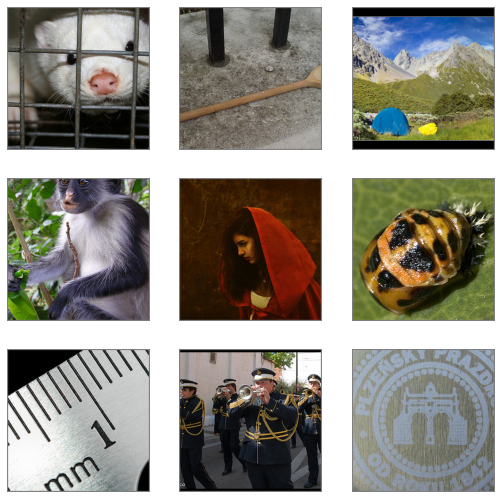

In [ ]:
show_images(denorm(xb[:9]))

## Making a model

In [ ]:
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

In [ ]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [ ]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)

In [ ]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [ ]:
lr = 1e-2
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

In [ ]:
learn.fit(epochs)

TypeError: unhashable type: 'slice'